In [40]:
using Plots
using Optim
using LinearAlgebra
include("markovvec.jl")

markov (generic function with 1 method)

In [41]:
N = 3000
m = 2
T = 400
iter = 10
velocities = 1000
EE, ratio_tentativas,energies,velocidades = markov(N,m,T,velocities,iter)

loop: 1
valor da variação da energia: -138190.52787160873
----------------------------------------- condição 1
tentativa 1
valor da variação da energia: -795603.2661371231
----------------------------------------- condição 1
tentativa 2
valor da variação da energia: -390204.9869084358
----------------------------------------- condição 1
tentativa 3
valor da variação da energia: -98924.228723526
----------------------------------------- condição 1
tentativa 4
valor da variação da energia: 481947.43667674065
----------------------------------------- condição 2
tentativa 5
valor da variação da energia: 419794.66075110435
----------------------------------------- condição 2
tentativa 6
valor da variação da energia: -209546.78730249405
----------------------------------------- condição 1
tentativa 7
valor da variação da energia: -901800.8706207275
----------------------------------------- condição 1
tentativa 8
valor da variação da energia: 1.2375808718070984e6
-----------------------------

Excessive output truncated after 524325 bytes.

valor da variação da energia: -156262.27449774742
----------------------------------------- condição 1
tentativa 4268
valor da variação da energia: -422447.5160443783
----------------------------------------- condição 1
tentativa 4269
valor da variação da energia: -400139.09291648865
----------------------------------------- condição 1
tentativa 4270
valor da variação da energia: -194694.0976600647
----------------------------------------- condição 1
tentativa 4271
valor da variação da energia: -168812.89042544365
----------------------------------------- condição 1
tentativa 4272
valor da variação da energia: 192406.29118680954
----------------------------------------- condição 2
tentativa 4273
valor da variação da energia: 97546.46831393242
----------------------------------------- condição 2
tentativa 4274
valor da variação da energia: -276101.9546763897
----------------------------------------- condição 1
tentativa 4275
valor da variação da energia: 720684.7033696175
--------------

(Any[135728.65673160553, -69064.78911590576, 397883.10321879387], 1.0, Any[1.997525441005035e9, 1.9629389911195421e9, 2.0249797604585795e9], [458.22753579750747 684.685259596052; 264.05937147460645 714.4408166106084; … ; -47.39336971141461 456.3663005533458; -669.0280976148031 534.6345438701558])

In [21]:
energies

10-element Vector{Any}:
 2.0041405443860315e11
 2.000896577402423e11
 1.9606213120117093e11
 1.988030404735497e11
 2.0227243603404053e11
 2.0163710684574506e11
 2.0099279497699207e11
 1.9546111356038947e11
 1.993781005137647e11
 2.0249960952114856e11

In [22]:
scalar = []
for i in 1:N
    push!(scalar,norm(velocidades[i,:]))
    end
scalar

3000-element Vector{Any}:
  7911.520224888779
  4145.641624056614
 10509.563788016356
 10533.157090887993
  2351.5698192385826
  3754.4877115755535
  7373.135981297951
  5830.376186098633
  7086.752605758979
  7473.768216565703
  8573.647762462862
  8044.746471170643
 10224.469544397962
     ⋮
  8223.276913424152
  2373.4839144286416
  8311.357155759822
  2590.3819176623324
  6468.510196316658
 11444.555977842048
 10304.696252954822
 10551.37739667224
  4401.197042981285
  7899.934188952403
  4043.4830498092524
  9057.855374586668

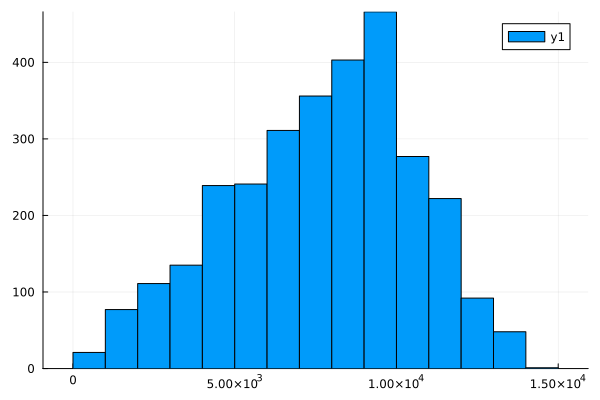

In [23]:
Plots.xlabel!("Velocidades escalar")
Plots.histogram(scalar)

Para plotar a curva, vai exigir com que eu selecione o intervalo de valores e isso eu posso fazer usando a velocidade que dei de entrada

In [24]:
mean(scalar)

7707.384361765231

In [25]:
N/velocities

0.3

In [26]:
scalar

3000-element Vector{Any}:
  7911.520224888779
  4145.641624056614
 10509.563788016356
 10533.157090887993
  2351.5698192385826
  3754.4877115755535
  7373.135981297951
  5830.376186098633
  7086.752605758979
  7473.768216565703
  8573.647762462862
  8044.746471170643
 10224.469544397962
     ⋮
  8223.276913424152
  2373.4839144286416
  8311.357155759822
  2590.3819176623324
  6468.510196316658
 11444.555977842048
 10304.696252954822
 10551.37739667224
  4401.197042981285
  7899.934188952403
  4043.4830498092524
  9057.855374586668

In [27]:
sort(scalar)

3000-element Vector{Any}:
   244.17015827249762
   455.89209407731494
   516.4969986929493
   531.9768028071567
   548.4947695607818
   552.1897373663043
   563.7232414008836
   666.1631655744856
   722.5619816201834
   740.4087216815125
   745.2684610371432
   749.8454926138821
   860.4222376149105
     ⋮
 13673.48634588896
 13689.91536264071
 13713.048595305045
 13721.444486901137
 13789.390786676071
 13831.766942122127
 13847.443267804305
 13854.798265354286
 13930.670451221926
 13953.810022504986
 13981.06767488549
 14007.16568003248

In [28]:
teto = floor(maximum(scalar)+1)

14008.0

In [29]:
classes = 30

30

In [30]:
Δv = teto/(teto/N)

3000.0

In [31]:
a = [i*Δv for i in 1:classes]
a

30-element Vector{Float64}:
  3000.0
  6000.0
  9000.0
 12000.0
 15000.0
 18000.0
 21000.0
 24000.0
 27000.0
 30000.0
 33000.0
 36000.0
 39000.0
     ⋮
 57000.0
 60000.0
 63000.0
 66000.0
 69000.0
 72000.0
 75000.0
 78000.0
 81000.0
 84000.0
 87000.0
 90000.0

In [32]:
frequencias = []
k = 1
f = 0
for i in sort(scalar)
    if i > a[k]
        push!(frequencias,f)
        k += 1
        f = 0
    end
    f +=1
end
push!(frequencias,f)

frequencias

5-element Vector{Any}:
  209
  615
 1070
  965
  141

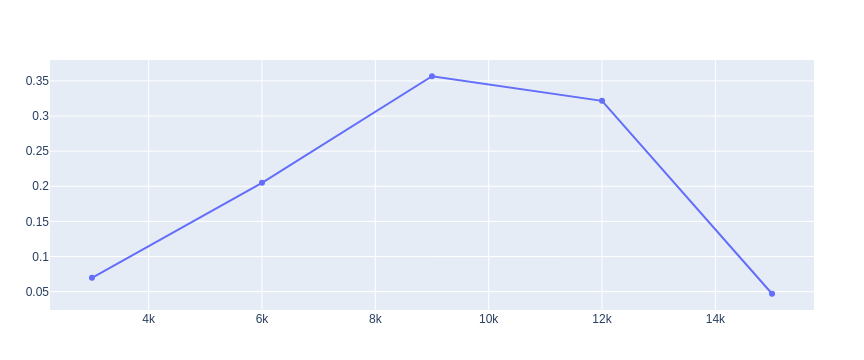

In [43]:
using Plotly

Plotly.plot(a,frequencias./N)